# Introduction

You are the new mayor of a mid-sized city in the southern United States. You campaigned on a promise to reduce crime and now it's time to make good. 

You have two promising programs aimed at those at highest risk of re-arrest. 

For the final project we are going to decide between these two programs.  

```
1) A custom notification program
Under this program, police officers visit the homes of high-risk individuals and notify them of their status. They additionally warn these individuals that the police is keeping a closer eye on them. The custom notification program is relatively cheap to run, so it can serve 1,000 individuals, but it will likely lead to more people being arrested.
```

```
2) A summer jobs program
Under this program, social workers visit the homes of high-risk individuals and offer them a slot in a summer jobs program which has been shown to be effective in increasing employment and reducing criminal justice involvement. The summer jobs program is expensive to run, so it can serve 500 individuals, but many of those served will likely not have been re-arrested even without the program. 
```

In [ ]:
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score as auc
from sklearn.ensemble import RandomForestClassifier as RF_clf
from sklearn.linear_model import LogisticRegression as LR_clf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# Part 1 


We will work with the following dataset:
 - **Xy**: Has the following columns 
   - `ArresteeID`: Unique ID for an arrestee
   - `outcome__rearrested_in_2019` : The outcome to predict
   - `charges__NIBRS_Group_X__YYYY` : This is a count of the number of charges of type X in the year YYYY. 
     - X is either A, B or C
     - YYYY is either 2016, 2017, or 2018
   - `arrests__race__XXXX` : Where XXXX is either Black, Hispanic, Other, or White
 - **arrests** : 
   - `IncidentNum`: Unique ID for an incident
   - `ArrestYr`: Year of arrest
   - `ArrestNumber`: Unique ID for an arrest
   - `ArWeapon` : Any weapons identified by the arresting officer
   - `arr_age`: Current age of arrestee
   - `arr_gender`: Gender of arrestee at incident
   - `ArresteeID`: Unique ID for an arrestee
 - **charges** : 
   - `ArrestNumber`: Unique ID for an arrest
   - `ArChgNumID`: Unique ID for an arrest charge
   - `Severity`: Misdemeanor or Felony
   - `NIBRS_Group`: Is charge of type A (most severe), B (less severe), or C (traffic incident)
   - `NIBRS_Crime_Category`: The category of the charge
 - **incidents** : 
   - `IncidentNum`: Unique ID for an incident
   - `incident_type`: Free text field describing the incident
   - `vic_type`: Whether the victim was a person, business, law enforcement, or the government 
   - `mo`: Free text field briefly describing the incident
   - `weapon_used`: Free text field listing the type of weapon if any
   - `gang_related`: Indication if the incident was gang-related
   
 
Both datasets have the following columns:
  - **`outcome__rearrested_in_2019`**: The actual outcome
  - **`race__Black`** : A binary-valued column with 1=Black 0=Not Black
  - **`race__White`** : A binary-valued column with 1=White 0=Not White
  - **`race__Hispanic`** : A binary-valued column with 1=Hispanic or Latino 0=Not Hispanic or Latino
  - **`gender__M`** : A binary-valued column with 1=Male gender and 0=Non-Male
  - **`network__any_1st_deg_nabe__all`** : A binary-valued column that tells us whether the person has ever been arrested with someone else
  - **`prediction` : The models predicted probability of the outcome

## Prediction Setup
Predicting whether someone arrested in 2018 will be re-arrested in 2019.



In [ ]:
Xy = pd.read_csv('./Xy_final_project.csv')
arrests = pd.read_csv('./arrests_final_project.csv')
charges = pd.read_csv('./charges_final_project.csv')
incidents = pd.read_csv('./incidents_final_project.csv')

Xy
arrests.head()
charges.head()
incidents.head()

,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,arrests__race__Black,arrests__race__Hispanic,arrests__race__Other,arrests__race__White
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0
3,2856607,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0,1,0,0
4,2921408,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12238,102720805,0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0
12239,102724697,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0
12240,102730586,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0
12241,102758342,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0


,IncidentNum,ArrestYr,ArrestNumber,ArWeapon,arr_age,arr_gender,ArresteeID
0,104552-2020,2020,20-018820,Unarmed,51.0,Male,102468259
1,104552-2020,2020,20-018820,Unarmed,51.0,Male,8607720
2,104552-2020,2020,20-018820,Unarmed,51.0,Male,102253069
3,104552-2020,2020,20-018820,Unarmed,51.0,Male,102366171
4,104552-2020,2020,20-018820,Unarmed,51.0,Male,102315487


,ArrestNumber,ArChgNumID,Severity,NIBRS_Group,NIBRS_Crime_Category
0,14-036903,14-036903-01,F,A,DRUG/ NARCOTIC VIOLATIONS
1,16-012390,16-012390-01,M,B,DRIVING UNDER THE INFLUENCE
2,15-048343,15-048343-01,M,B,PUBLIC INTOXICATION
3,16-015720,16-015720-03,M,C,TRAFFIC VIOLATION - NON HAZARDOUS
4,15-040648,15-040648-01,M,B,DRIVING UNDER THE INFLUENCE


,IncidentNum,incident_type,vic_type,mo,weapon_used,gang_related
0,207055-2018,ASSAULT -PUB SERV (PEACE OFFICER/JUDGE),Law Enforcement Offi,A/P BIT OFFICER ON THE LEFT HAND CAUSING INJURY,Personal Weapons (Hands-Feet ETC),UNK
1,243817-2018,TRAF VIO -OPERATE MOTOR VEH W/O FIN RESP,Government,A/P WAS UNABLE TO PROVIDE PROOF OF INSURANCE,NaN,NaN
2,245226-2018,OTHER OFFENSE - MISDEMEANOR,Government,AP WAS IN POSSESSION OF DRUG PARAPHERNALIA,NaN,NaN
3,133767-2019,POSS MARIJUANA <2OZ,Government,A/P WAS IN POSSESSION OF MARIJUANA.,NaN,NaN
4,273676-2018,POSS CONT SUB PEN GRP 1 <1G,Government,AP WAS IN POSSESSION OF COCAINE,NaN,NaN


## Learning about our outcome 




In [ ]:
Xy['count']=Xy['charges__NIBRS_Group_A__2018']+Xy['charges__NIBRS_Group_B__2018']+Xy['charges__NIBRS_Group_C__2018']
Xy['count'].value_counts()
arrest2018=Xy['count'].count()-3
arrest2019=Xy["outcome__rearrested_in_2019"].value_counts()[1]
share=arrest2019/arrest2018
print('The share of 2018 arrestees were arrested in 2019 is ' +str(share) +'. It is a low base rate')


1.0     8277
2.0     2276
3.0      864
4.0      392
5.0      177
6.0       87
7.0       56
9.0       10
13.0      10
11.0       9
8.0        9
0.0        3
Name: count, dtype: int64

The share of 2018 arrestees were arrested in 2019 is 0.07273773321278869. It is a low base rate


In [ ]:
df_black=Xy.drop(Xy[Xy.arrests__race__Black != 1].index)
df_black['count']=df_black['charges__NIBRS_Group_A__2018']+df_black['charges__NIBRS_Group_B__2018']+df_black['charges__NIBRS_Group_C__2018']
df_black['count'].value_counts()
black2018=df_black['count'].count()-3
arrestblack=df_black["outcome__rearrested_in_2019"].value_counts()[1]
blackshare=arrestblack/black2018
blackshare

df_Hispanic=Xy.drop(Xy[Xy.arrests__race__Hispanic != 1].index)
df_Hispanic['count']=df_Hispanic['charges__NIBRS_Group_A__2018']+df_Hispanic['charges__NIBRS_Group_B__2018']+df_Hispanic['charges__NIBRS_Group_C__2018']
df_Hispanic['count'].value_counts()
Hispanic2018=df_Hispanic['count'].count()
arrestHispanic=df_Hispanic["outcome__rearrested_in_2019"].value_counts()[1]
Hispanicshare=arrestHispanic/Hispanic2018
Hispanicshare

df_Other=Xy.drop(Xy[Xy.arrests__race__Other != 1].index)
df_Other['count']=df_Other['charges__NIBRS_Group_A__2018']+df_Other['charges__NIBRS_Group_B__2018']+df_Other['charges__NIBRS_Group_C__2018']
df_Other['count'].value_counts()
Other2018=df_Other['count'].count()
arrestOther=df_Other["outcome__rearrested_in_2019"].value_counts()[1]
Othershare=arrestOther/Other2018
Othershare


df_White=Xy.drop(Xy[Xy.arrests__race__White != 1].index)
df_White['count']=df_White['charges__NIBRS_Group_A__2018']+df_White['charges__NIBRS_Group_B__2018']+df_White['charges__NIBRS_Group_C__2018']
df_White['count'].value_counts()
White2018=df_White['count'].count()
arrestWhite=df_White["outcome__rearrested_in_2019"].value_counts()[1]
Whiteshare=arrestWhite/White2018
Whiteshare

print('\nThe black race group has the highest base rate of '+str(blackshare))

1.0     3355
2.0     1254
3.0      471
4.0      251
5.0      104
6.0       47
7.0       36
9.0       10
13.0      10
8.0        5
0.0        3
Name: count, dtype: int64

0.08461122136027421

1.0     2674
2.0      600
3.0      234
4.0       90
5.0       32
6.0       17
7.0       11
11.0       9
8.0        4
Name: count, dtype: int64

0.0593843639335331

1.0    167
2.0     26
3.0     10
4.0      2
Name: count, dtype: int64

0.06829268292682927

1.0    2081
2.0     396
3.0     149
4.0      49
5.0      41
6.0      23
7.0       9
Name: count, dtype: int64

0.06695778748180495


The black race group has the highest base rate of 0.08461122136027421


## Feature Generation 


 
 
 

In [ ]:
new_incidents = incidents.merge(arrests, on='IncidentNum', how='left')
incidents_2018=new_incidents[new_incidents.ArrestYr==2018]
dummied_columns=pd.concat([incidents_2018[['ArresteeID']],pd.get_dummies(incidents_2018.vic_type, prefix='type_',dummy_na=False)],axis=1)
dummied_columns=dummied_columns[['ArresteeID','type__Business', 'type__Government']]
Xy=Xy.merge(dummied_columns,on='ArresteeID',how='left').fillna(0)
Xy



,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,arrests__race__Black,arrests__race__Hispanic,arrests__race__Other,arrests__race__White,count,type__Business,type__Government
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1.0,0.0,1.0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1.0,0.0,1.0
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,5.0,0.0,0.0
3,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,5.0,0.0,0.0
4,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19966,102724697,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0,1.0,0.0,1.0
19967,102730586,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,2.0,0.0,1.0
19968,102730586,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,2.0,0.0,0.0
19969,102758342,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1.0,0.0,1.0


<AxesSubplot:xlabel='type__Government', ylabel='outcome__rearrested_in_2019'>

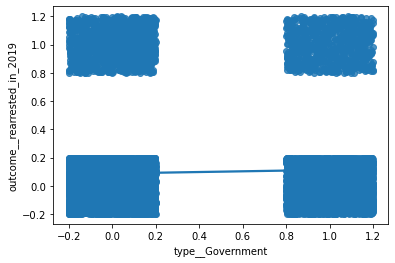

In [ ]:
sns.regplot(data=Xy, x='type__Government',y='outcome__rearrested_in_2019', x_jitter=.2,y_jitter=.2)


<AxesSubplot:xlabel='type__Business', ylabel='outcome__rearrested_in_2019'>

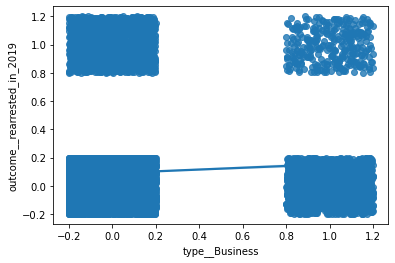

In [ ]:
sns.regplot(data=Xy, x='type__Business',y='outcome__rearrested_in_2019', x_jitter=.2,y_jitter=.2)

In [ ]:
print('vic type of govement is more predictive')

vic type of govement is more predictive


## Build models 

1) 
These are the set of features to include in the first model.
```
feature_names = ['charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White']
```


2) 2nd model
```
feature_names ='charges__NIBRS_Group_A__2016', 
                 'charges__NIBRS_Group_A__2017',
                 'charges__NIBRS_Group_A__2018',
                 'charges__NIBRS_Group_B__2016',
                 'charges__NIBRS_Group_B__2017',
                 'charges__NIBRS_Group_B__2018',
                 'charges__NIBRS_Group_C__2016', 
                 'charges__NIBRS_Group_C__2017',
                 'charges__NIBRS_Group_C__2018', 
                 'arrests__race__Black',
                 'arrests__race__Hispanic', 
                 'arrests__race__Other',
                 'arrests__race__White',
                 'type__Business',
                 'type__Government'
```




In [ ]:
feature_names = ['charges__NIBRS_Group_A__2016', 
                 'charges__NIBRS_Group_A__2017',
                 'charges__NIBRS_Group_A__2018',
                 'charges__NIBRS_Group_B__2016',
                 'charges__NIBRS_Group_B__2017',
                 'charges__NIBRS_Group_B__2018',
                 'charges__NIBRS_Group_C__2016', 
                 'charges__NIBRS_Group_C__2017',
                 'charges__NIBRS_Group_C__2018', 
                 'arrests__race__Black',
                 'arrests__race__Hispanic', 
                 'arrests__race__Other',
                 'arrests__race__White']
outcome = 'outcome__rearrested_in_2019'
X_train, X_test, y_train, y_test = train_test_split(Xy, Xy[outcome], test_size=.3)

rf_model = RF_clf()

param_grid = {'max_depth' : [1, 5, 10],
              'max_features' : [1, 2, 3],
             'n_estimators' : [200]}

gs_cv = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='average_precision')

gs_cv.fit(X_train[feature_names], y_train)

test_results= pd.DataFrame({'outcome__rearrested_in_2019' : y_test, 
                                'charges__NIBRS_Group_A__2016' : X_test['charges__NIBRS_Group_A__2016'],
                             'charges__NIBRS_Group_A__2017' : X_test['charges__NIBRS_Group_A__2017'],
                             'charges__NIBRS_Group_A__2018' : X_test['charges__NIBRS_Group_A__2018'],               
                                'charges__NIBRS_Group_B__2016' : X_test['charges__NIBRS_Group_B__2016'],
                             'charges__NIBRS_Group_B__2017' : X_test['charges__NIBRS_Group_B__2017'],
                             'charges__NIBRS_Group_B__2018' : X_test['charges__NIBRS_Group_B__2018'],                       
                                'charges__NIBRS_Group_C__2016' : X_test['charges__NIBRS_Group_C__2016'],
                             'charges__NIBRS_Group_C__2017' : X_test['charges__NIBRS_Group_C__2017'],
                             'charges__NIBRS_Group_C__2018' : X_test['charges__NIBRS_Group_C__2018'],                                                           
                             'race__Black' : X_test['arrests__race__Black'],
                             'race__White' : X_test['arrests__race__Hispanic'],
                             'race__Hispanic' : X_test['arrests__race__White'],
                                'race__Other' : X_test['arrests__race__Other'],
                             'predictions_standard' : gs_cv.predict_proba(X_test[feature_names])[:, 1]})
test_results

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10], 'max_features': [1, 2, 3],
                         'n_estimators': [200]},
             scoring='average_precision')

,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,race__Black,race__White,race__Hispanic,race__Other,predictions_standard
1110,0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1,0,0,0,0.192945
18358,0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,0.096111
8816,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0.074303
12549,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,0.050436
14248,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,0.050436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.066811
17403,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.066811
9770,0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,1,0,0,0,0.019674
6004,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0.068619


In [ ]:
new_feature_names = ['charges__NIBRS_Group_A__2016', 
                 'charges__NIBRS_Group_A__2017',
                 'charges__NIBRS_Group_A__2018',
                 'charges__NIBRS_Group_B__2016',
                 'charges__NIBRS_Group_B__2017',
                 'charges__NIBRS_Group_B__2018',
                 'charges__NIBRS_Group_C__2016', 
                 'charges__NIBRS_Group_C__2017',
                 'charges__NIBRS_Group_C__2018', 
                 'arrests__race__Black',
                 'arrests__race__Hispanic', 
                 'arrests__race__Other',
                 'arrests__race__White',
                 'type__Business',
                 'type__Government']
new_outcome = 'outcome__rearrested_in_2019'
X_train, X_test, y_train, y_test = train_test_split(Xy, Xy[new_outcome], test_size=.3)

new_rf_model = RF_clf()

new_param_grid = {'max_depth' : [1, 5, 10],
              'max_features' : [1, 2, 3],
             'n_estimators' : [200]}

new_gs_cv = GridSearchCV(estimator=new_rf_model, param_grid=new_param_grid, cv=5, scoring='average_precision')

new_gs_cv.fit(X_train[new_feature_names], y_train)

new_test_results= pd.DataFrame({'outcome__rearrested_in_2019' : y_test, 
                                'charges__NIBRS_Group_A__2016' : X_test['charges__NIBRS_Group_A__2016'],
                             'charges__NIBRS_Group_A__2017' : X_test['charges__NIBRS_Group_A__2017'],
                             'charges__NIBRS_Group_A__2018' : X_test['charges__NIBRS_Group_A__2018'],               
                                'charges__NIBRS_Group_B__2016' : X_test['charges__NIBRS_Group_B__2016'],
                             'charges__NIBRS_Group_B__2017' : X_test['charges__NIBRS_Group_B__2017'],
                             'charges__NIBRS_Group_B__2018' : X_test['charges__NIBRS_Group_B__2018'],                       
                                'charges__NIBRS_Group_C__2016' : X_test['charges__NIBRS_Group_C__2016'],
                             'charges__NIBRS_Group_C__2017' : X_test['charges__NIBRS_Group_C__2017'],
                             'charges__NIBRS_Group_C__2018' : X_test['charges__NIBRS_Group_C__2018'],                                                           
                             'race__Black' : X_test['arrests__race__Black'],
                             'race__White' : X_test['arrests__race__Hispanic'],
                             'race__Hispanic' : X_test['arrests__race__White'],
                                'race__Other' : X_test['arrests__race__Other'],
                                'type__Business' : X_test['type__Business'],
                                'type__Governmen' : X_test['type__Government'],
                             'predictions_augmented' : new_gs_cv.predict_proba(X_test[new_feature_names])[:, 1]})
new_test_results

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10], 'max_features': [1, 2, 3],
                         'n_estimators': [200]},
             scoring='average_precision')

,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,race__Black,race__White,race__Hispanic,race__Other,type__Business,type__Governmen,predictions_augmented
6245,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0,0.064273
13677,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0.0,1.0,0.073143
9383,1,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1,0,0,0,1.0,0.0,0.925140
14486,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0.0,1.0,0.051488
8832,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1,0,0,0,0.0,1.0,0.138448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12397,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1.0,0.0,0.108858
9195,0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0,0.065533
8348,0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0,1,0,0.0,1.0,0.047457
19884,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.061254


##  Model performance 

In [ ]:
test_results.sort_values('predictions_standard', ascending=False, inplace=True)
test_results.outcome__rearrested_in_2019.mean()

0.09763017356475301

In [ ]:
test_results['yhat'] = test_results.predictions_standard > .095
confusion_matrix = pd.crosstab(test_results.yhat, test_results.outcome__rearrested_in_2019)
confusion_matrix

outcome__rearrested_in_2019,0,1
yhat,,
False,4627,252
True,780,333


In [ ]:
prec = confusion_matrix.iloc[1, 1] / confusion_matrix.iloc[1, :].sum()
print('PPV:', prec)
recall = confusion_matrix.iloc[1, 1] / confusion_matrix.iloc[:, 1].sum()
print('TPR:', recall)
auc_result=auc(test_results.outcome__rearrested_in_2019,test_results.predictions_standard)
print('AUC:', auc_result)

PPV: 0.2991913746630728
TPR: 0.5692307692307692
AUC: 0.7839582750439048


In [ ]:
new_test_results.sort_values('predictions_augmented', ascending=False, inplace=True)
new_test_results.outcome__rearrested_in_2019.mean()

0.09929906542056074

In [ ]:
new_test_results['yhat'] = new_test_results.predictions_augmented > .095
new_confusion_matrix = pd.crosstab(new_test_results.yhat, new_test_results.outcome__rearrested_in_2019)
new_confusion_matrix

outcome__rearrested_in_2019,0,1
yhat,,
False,4723,250
True,674,345


In [ ]:
prec = new_confusion_matrix.iloc[1, 1] / new_confusion_matrix.iloc[1, :].sum()
print('PPV:', prec)
recall = new_confusion_matrix.iloc[1, 1] /new_confusion_matrix.iloc[:, 1].sum()
print('TPR:', recall)
new_auc=auc(new_test_results.outcome__rearrested_in_2019,new_test_results.predictions_augmented)
print('AUC:', new_auc)

PPV: 0.338567222767419
TPR: 0.5798319327731093
AUC: 0.8001655136762876


# Part 2
Decide whether to select the custom notification or summer jobs program.



In [ ]:
print('prediction_augmented')

prediction_augmented


## Total Impact



In [ ]:
arrest_2019=new_test_results['outcome__rearrested_in_2019'].sum()
top500_arrest=new_test_results.iloc[:500]['outcome__rearrested_in_2019'].sum()
top1000_arrest= new_test_results.iloc[:1000]['outcome__rearrested_in_2019'].sum()
print('The number of arrests in 2019 is ' +str(arrest_2019))
print('The number of arrests that would be accounted for by the top 500 in predicted risk is '+str(top500_arrest))
print('The number of arrests that would be accounted for by the top 1,000 in predicted risk is '+str(top1000_arrest))

The number of arrests in 2019 is 595
The number of arrests that would be accounted for by the top 500 in predicted risk is 276
The number of arrests that would be accounted for by the top 1,000 in predicted risk is 344


In [ ]:
half_rearrest=top1000_arrest/2
new_arrest_rate=half_rearrest/arrest_2019
print('The percentage of 2019 arrests would be eliminated if the custom notification program targeted the top 1,000 and reduced re-arrest by 50% is '+str(new_arrest_rate))
summer_rearrest=top500_arrest/arrest_2019
print('The percentage of 2019 arrests would be eliminated if the summer jobs program targeted the top 500 and reduced re-arrest by 100% is '+str(summer_rearrest) )

The percentage of 2019 arrests would be eliminated if the custom notification program targeted the top 1,000 and reduced re-arrest by 50% is 0.28907563025210087
The percentage of 2019 arrests would be eliminated if the summer jobs program targeted the top 500 and reduced re-arrest by 100% is 0.4638655462184874


In [ ]:
charges.Severity.value_counts()
felony_num=27064
sum_felony_prevented=felony_num*summer_rearrest
print('The number of felony arrests that would be prevented by summer jobs is '+str(sum_felony_prevented))
cus_felony_prevented=felony_num*new_arrest_rate
print('The number of felony arrests that would be prevented by custom notifications is '+str(cus_felony_prevented))

M    85304
F    27064
N     3528
Name: Severity, dtype: int64

The number of felony arrests that would be prevented by summer jobs is 12554.057142857144
The number of felony arrests that would be prevented by custom notifications is 7823.542857142858


## Calculating Cost 




## Fairness

### FPR balance


### Precision 



In [ ]:
feature_names = ['charges__NIBRS_Group_A__2016', 
                 'charges__NIBRS_Group_A__2017',
                 'charges__NIBRS_Group_A__2018',
                 'charges__NIBRS_Group_B__2016',
                 'charges__NIBRS_Group_B__2017',
                 'charges__NIBRS_Group_B__2018',
                 'charges__NIBRS_Group_C__2016', 
                 'charges__NIBRS_Group_C__2017',
                 'charges__NIBRS_Group_C__2018', 
                 'arrests__race__Black',
                 'arrests__race__Hispanic', 
                 'arrests__race__Other',
                 'arrests__race__White']
outcome = 'outcome__rearrested_in_2019'
X_train, X_test, y_train, y_test = train_test_split(Xy, Xy[outcome], test_size=.3)





In [ ]:
rf_model = RF_clf()

param_grid = {'max_depth' : [1, 5, 10],
              'max_features' : [1, 2, 3],
             'n_estimators' : [200]}

gs_cv = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='average_precision')

gs_cv.fit(X_train[feature_names], y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10], 'max_features': [1, 2, 3],
                         'n_estimators': [200]},
             scoring='average_precision')

In [ ]:
test_results_w_race= pd.DataFrame({'outcome__rearrested_in_2019' : y_test, 
                                                                                        
                             'race__Black' : X_test['arrests__race__Black'],
                             'race__White' : X_test['arrests__race__Hispanic'],
                             'race__Hispanic' : X_test['arrests__race__White'],
                                'race__Other' : X_test['arrests__race__Other'],
                             'predictions' : gs_cv.predict_proba(X_test[feature_names])[:, 1]})
test_results_w_race

,outcome__rearrested_in_2019,race__Black,race__White,race__Hispanic,race__Other,predictions
15670,0,1,0,0,0,0.148668
14537,0,1,0,0,0,0.078249
11605,0,1,0,0,0,0.078249
10551,1,0,1,0,0,0.990259
19795,0,1,0,0,0,0.121678
...,...,...,...,...,...,...
9675,0,0,1,0,0,0.040604
12458,0,1,0,0,0,0.078249
12666,0,0,1,0,0,0.060730
6010,0,0,1,0,0,0.052836


In [ ]:
threshold = y_train.mean()
test_results_w_race['yhat'] = (test_results_w_race.predictions > threshold).map({True : 1, False: 0})
test_results_w_race

,outcome__rearrested_in_2019,race__Black,race__White,race__Hispanic,race__Other,predictions,yhat
15670,0,1,0,0,0,0.148668,1
14537,0,1,0,0,0,0.078249,0
11605,0,1,0,0,0,0.078249,0
10551,1,0,1,0,0,0.990259,1
19795,0,1,0,0,0,0.121678,1
...,...,...,...,...,...,...,...
9675,0,0,1,0,0,0.040604,0
12458,0,1,0,0,0,0.078249,0
12666,0,0,1,0,0,0.060730,0
6010,0,0,1,0,0,0.052836,0


In [ ]:
test_results_w_race_1000=test_results_w_race[:1000]
confusion_matrix_Black = pd.crosstab(test_results_w_race_1000[test_results_w_race_1000.race__Black==1].yhat, 
                                     test_results_w_race_1000[test_results_w_race_1000.race__Black==1].outcome__rearrested_in_2019)
confusion_matrix_Black
confusion_matrix_Hispanic = pd.crosstab(test_results_w_race_1000[test_results_w_race_1000.race__Hispanic==1].yhat, 
                                     test_results_w_race_1000[test_results_w_race_1000.race__Hispanic==1].outcome__rearrested_in_2019)
confusion_matrix_Hispanic
confusion_matrix_White = pd.crosstab(test_results_w_race_1000[test_results_w_race_1000.race__White==1].yhat, 
                                     test_results_w_race_1000[test_results_w_race_1000.race__White==1].outcome__rearrested_in_2019)
confusion_matrix_White

outcome__rearrested_in_2019,0,1
yhat,,
0,360,16
1,80,22


outcome__rearrested_in_2019,0,1
yhat,,
0,167,10
1,23,17


outcome__rearrested_in_2019,0,1
yhat,,
0,241,13
1,15,15


In [ ]:
#fpr
print('FPR, Black:', confusion_matrix_Black.iloc[1, 0] / confusion_matrix_Black.iloc[:, 0].sum())
print('FPR, Hispanic:', confusion_matrix_White.iloc[1, 0] / confusion_matrix_White.iloc[:, 0].sum())
print('FPR, White:', confusion_matrix_Hispanic.iloc[1, 0] / confusion_matrix_Hispanic.iloc[:, 0].sum())

FPR, Black: 0.18181818181818182
FPR, Hispanic: 0.05859375
FPR, White: 0.12105263157894737


In [ ]:
test_results_w_race_500=test_results_w_race[:500]
confusion_matrix_Black = pd.crosstab(test_results_w_race_500[test_results_w_race_500.race__Black==1].yhat, 
                                     test_results_w_race_500[test_results_w_race_500.race__Black==1].outcome__rearrested_in_2019)
confusion_matrix_Black
confusion_matrix_Hispanic = pd.crosstab(test_results_w_race_500[test_results_w_race_500.race__Hispanic==1].yhat, 
                                     test_results_w_race_500[test_results_w_race_500.race__Hispanic==1].outcome__rearrested_in_2019)
confusion_matrix_Hispanic
confusion_matrix_White = pd.crosstab(test_results_w_race_500[test_results_w_race_500.race__White==1].yhat, 
                                     test_results_w_race_500[test_results_w_race_500.race__White==1].outcome__rearrested_in_2019)
confusion_matrix_White

outcome__rearrested_in_2019,0,1
yhat,,
0,185,4
1,46,11


outcome__rearrested_in_2019,0,1
yhat,,
0,79,5
1,13,8


outcome__rearrested_in_2019,0,1
yhat,,
0,119,6
1,9,6


In [ ]:
#precition
print('PPV, Black:', confusion_matrix_Black.iloc[1, 1] / confusion_matrix_Black.iloc[1, :].sum())
print('PPV, Hispanic:', confusion_matrix_White.iloc[1, 1] / confusion_matrix_White.iloc[1, :].sum())
print('PPV, White:', confusion_matrix_Hispanic.iloc[1, 1] / confusion_matrix_Hispanic.iloc[1, :].sum())

PPV, Black: 0.19298245614035087
PPV, Hispanic: 0.4
PPV, White: 0.38095238095238093


# Part 3: Putting It All Together

***From the predictive performance perspective, we got low PPV(0.299
), which indicates our prediction is not that accurate. We also got 
the TPR of 0.56, we also just get approximately 50% correct, 
which reveals our prediction is not that successful.In terms 
of potential impact, The percentage of 2019 arrests that 
would be eliminated is 0.285 for custom notification program 
compared to 0.458 (the percentage of 2019 arrests of summer 
jobs program ), which reveals that the summer jobs 
program works better. In terms of Cost-Effectiveness, 
the cost per person for the summer job program (4230.11) 
is way more expensive than the custom notification program(1692.04). 
In other words, using the custom notification program will dramatically 
decrease the financial pressure of the government. In terms of fairness
consideration, the black group (0.22 PPV)does not have the highest 
positive predictive value even though they have the highest base 
rate, which indicates the summer job program failed the goal. 
For the custom notification program, the FPR for the black 
group(0.19), the Hispanic group(0.02), and the white group(0.08) 
are not close enough, which means the program is not going to 
potentially limit people's civil liberties. Thus, custom 
notification program works better in this case.  
In conclusion, I will suggest using the custom notification 
program. It will affect the felony arrests since the whole 
rearrest rate changes.***